# Static Yaw Misalignment MVP


## WeDoWind Rapperswil 2024-06-18

This notebook is designed to show a simple static yaw misalignment analysis using a single year of the data from Kelmarsh wind farm

## Collaborative coding

Feel free to edit and change the code, but this will change it for everyone! :D

Please add commentary where appropriate, and propose changes and improvements for others to perform.

## Improvements

- Functionise the code
- Expand to more turbines
- Include the yaw misalginment frequency distribution
- Improve the power curve filtering
- Improve the comments and Markdown
- Propose your own improvements

In [1]:
import requests
from pathlib import Path
from tqdm import tqdm
import logging
import re
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import zipfile

from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularPredictor


d:\GitHub\wedowind-sye\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
target_turbine = "Kelmarsh_1"
autoML_duration_mins = 5

In [2]:
logger = logging.getLogger()

In [3]:
BYTES_MB = 1024 * 1024

In [4]:

def download_file(url: str, outfile: str | Path) -> None:
    """
    Download a file from the web, based on its url, and save to the outfile.

    Args:
        url(:obj:`str`): Url of data to download.
        outfile(:obj:`str` | :obj:`Path`): File path to which the download is saved.
    """

    outfile = Path(outfile).resolve()
    result = requests.get(url, stream=True)

    with outfile.open("wb") as f:
        for chunk in tqdm(result.iter_content(chunk_size=BYTES_MB), desc="MB downloaded"):
            if chunk:
                f.write(chunk)


In [5]:
url = r"https://zenodo.org/records/8252025/files/Kelmarsh_12.3MW_6xSenvion_MM92.kmz?download=1"
outfile = Path("Kelmarsh_12.3MW_6xSenvion_MM92.kmz")

if not outfile.is_file():
    download_file(url,outfile)


In [6]:
url = r"https://zenodo.org/records/8252025/files/Kelmarsh_SCADA_2022_4457.zip?download=1"
outfile = Path("Kelmarsh_SCADA_2022_4457.zip")

if not outfile.is_file():
    download_file(url,outfile)

with zipfile.ZipFile(outfile,"r") as zip_ref:
    zip_ref.extractall()


In [7]:
scada_files = list(Path().rglob("Turbine_Data*.csv"))

In [8]:
use_columns = [
            "# Date and time",
            "Power (kW)",
            "Wind speed (m/s)",
            "Wind direction (°)",
            "Nacelle position (°)",
            "Blade angle (pitch position) A (°)",
        ]

csv_params = {
        "index_col": "# Date and time",
        "parse_dates": True,
        "skiprows": 9,
        "usecols": use_columns,
    }

In [9]:
str(scada_files[0])[-42:-32]

'Kelmarsh_1'

In [10]:
scada_lst = []

for file in scada_files:
    turbine_name = str(file)[-42:-32] # TODO - should take name of file not the full path

    scada_wt = pd.read_csv(file, **csv_params)

    scada_wt["Turbine"] = turbine_name
    scada_wt.index.names = ["Timestamp"]
    scada_lst.append(scada_wt.copy())

scada = pd.concat(scada_lst)

In [11]:
scada

,Wind speed (m/s),Wind direction (°),Nacelle position (°),Power (kW),Blade angle (pitch position) A (°),Turbine
Timestamp,,,,,,
2022-01-01 00:00:00,6.781222,185.795348,193.731354,630.889598,0.0000,Kelmarsh_1
2022-01-01 00:10:00,6.936052,189.458687,193.731354,809.339449,0.0000,Kelmarsh_1
2022-01-01 00:20:00,7.294642,188.648729,193.731354,893.607333,0.0470,Kelmarsh_1
2022-01-01 00:30:00,8.080467,188.826550,193.731354,995.583734,0.0065,Kelmarsh_1
2022-01-01 00:40:00,7.021328,191.252213,193.731354,926.519441,0.0060,Kelmarsh_1
...,...,...,...,...,...,...
2022-12-31 23:10:00,8.712688,210.193670,205.457916,1447.101428,0.1090,Kelmarsh_6
2022-12-31 23:20:00,9.149686,208.465164,205.457916,1572.766687,0.3910,Kelmarsh_6
2022-12-31 23:30:00,9.571797,213.539677,205.457916,1653.457245,1.1805,Kelmarsh_6


In [12]:
scada["Yaw error"] = (scada["Nacelle position (°)"] - scada["Wind direction (°)"]+180)%360-180 # TODO - circular difference rather than absolute

<Axes: xlabel='Timestamp'>

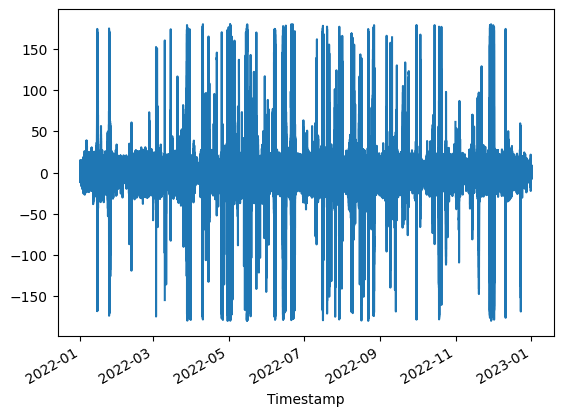

In [13]:
scada["Yaw error"].plot()

In [ ]:
kelmarsh_1 = scada[scada["Turbine"]==target_turbine].drop(columns="Turbine")

In [15]:
kelmarsh_1

,Wind speed (m/s),Wind direction (°),Nacelle position (°),Power (kW),Blade angle (pitch position) A (°),Yaw error
Timestamp,,,,,,
2022-01-01 00:00:00,6.781222,185.795348,193.731354,630.889598,0.0000,7.936005
2022-01-01 00:10:00,6.936052,189.458687,193.731354,809.339449,0.0000,4.272666
2022-01-01 00:20:00,7.294642,188.648729,193.731354,893.607333,0.0470,5.082625
2022-01-01 00:30:00,8.080467,188.826550,193.731354,995.583734,0.0065,4.904804
2022-01-01 00:40:00,7.021328,191.252213,193.731354,926.519441,0.0060,2.479140
...,...,...,...,...,...,...
2022-12-31 23:10:00,9.518300,205.225957,213.708250,1704.398523,0.7090,8.482293
2022-12-31 23:20:00,9.730098,205.757749,209.097260,1572.972638,0.9735,3.339510
2022-12-31 23:30:00,9.848731,212.715798,209.097260,1839.576129,1.6315,-3.618538


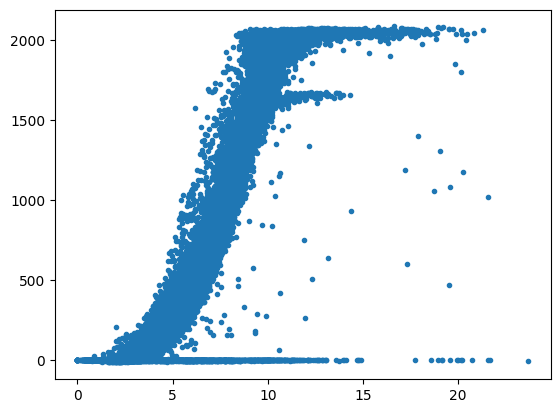

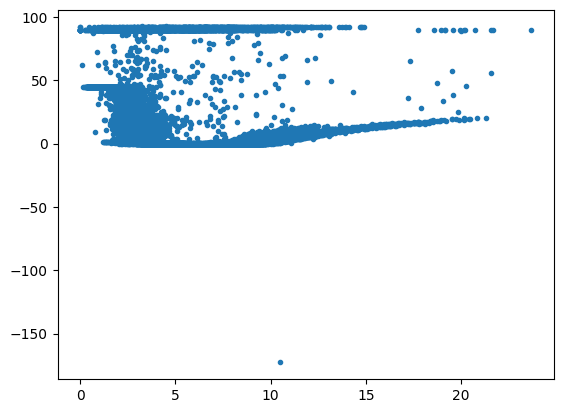

In [16]:
power_curve = plt.figure()
plt.plot(kelmarsh_1["Wind speed (m/s)"],kelmarsh_1["Power (kW)"],marker='.',linestyle='')

pitch_curve = plt.figure()
plt.plot(kelmarsh_1["Wind speed (m/s)"],kelmarsh_1["Blade angle (pitch position) A (°)"],marker='.',linestyle='')


In [17]:
kelmarsh_1_filtered = kelmarsh_1[(kelmarsh_1["Blade angle (pitch position) A (°)"]<1.5) 
                                 & (kelmarsh_1["Blade angle (pitch position) A (°)"]>-1.5)]

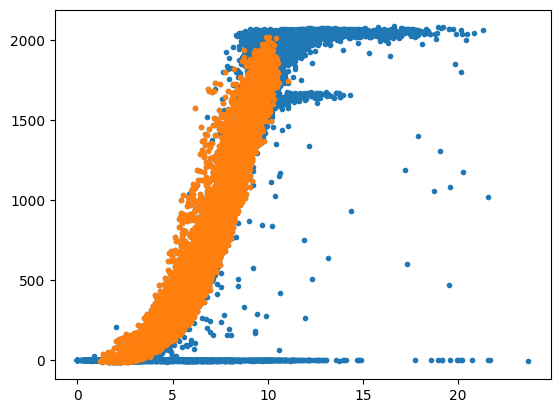

In [18]:
plt.figure(power_curve)
plt.plot(kelmarsh_1_filtered["Wind speed (m/s)"],kelmarsh_1_filtered["Power (kW)"],marker='.',linestyle='')
plt.show()

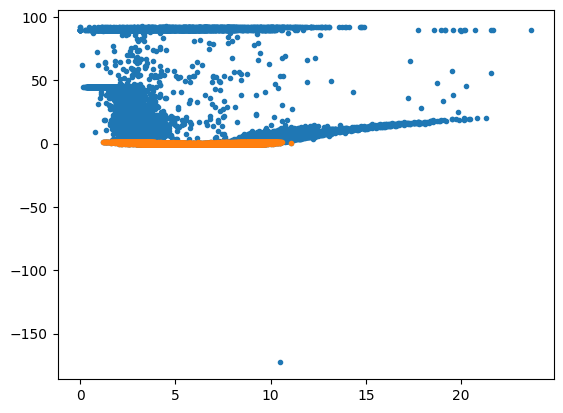

In [19]:
plt.figure(pitch_curve)
plt.plot(kelmarsh_1_filtered["Wind speed (m/s)"],kelmarsh_1_filtered["Blade angle (pitch position) A (°)"],marker='.',linestyle='')
plt.show()

In [20]:
kelmarsh_1_filtered

,Wind speed (m/s),Wind direction (°),Nacelle position (°),Power (kW),Blade angle (pitch position) A (°),Yaw error
Timestamp,,,,,,
2022-01-01 00:00:00,6.781222,185.795348,193.731354,630.889598,0.000000,7.936005
2022-01-01 00:10:00,6.936052,189.458687,193.731354,809.339449,0.000000,4.272666
2022-01-01 00:20:00,7.294642,188.648729,193.731354,893.607333,0.047000,5.082625
2022-01-01 00:30:00,8.080467,188.826550,193.731354,995.583734,0.006500,4.904804
2022-01-01 00:40:00,7.021328,191.252213,193.731354,926.519441,0.006000,2.479140
...,...,...,...,...,...,...
2022-12-31 22:40:00,8.943925,222.929987,227.755859,1437.142835,0.259474,4.825872
2022-12-31 22:50:00,8.366701,216.027913,220.507626,1108.914258,0.000000,4.479713
2022-12-31 23:00:00,9.200417,212.180970,215.682648,1434.521783,0.469000,3.501678


## A crude static yaw misalignment analysis

In [21]:
ws_bins=[5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
vane_bins=np.linspace(-25,25,51)

kelmarsh_1_filtered['ws_bin'] = pd.cut(kelmarsh_1_filtered['Wind speed (m/s)'], ws_bins)
kelmarsh_1_filtered['yaw_bin'] = pd.cut(kelmarsh_1_filtered['Yaw error'], vane_bins)

C:\Users\Charlie\AppData\Local\Temp\ipykernel_14256\2905804845.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kelmarsh_1_filtered['ws_bin'] = pd.cut(kelmarsh_1_filtered['Wind speed (m/s)'], ws_bins)
C:\Users\Charlie\AppData\Local\Temp\ipykernel_14256\2905804845.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kelmarsh_1_filtered['yaw_bin'] = pd.cut(kelmarsh_1_filtered['Yaw error'], vane_bins)


In [22]:
kelmarsh_1_filtered

,Wind speed (m/s),Wind direction (°),Nacelle position (°),Power (kW),Blade angle (pitch position) A (°),Yaw error,ws_bin,yaw_bin
Timestamp,,,,,,,,
2022-01-01 00:00:00,6.781222,185.795348,193.731354,630.889598,0.000000,7.936005,"(6.0, 7.0]","(7.0, 8.0]"
2022-01-01 00:10:00,6.936052,189.458687,193.731354,809.339449,0.000000,4.272666,"(6.0, 7.0]","(4.0, 5.0]"
2022-01-01 00:20:00,7.294642,188.648729,193.731354,893.607333,0.047000,5.082625,"(7.0, 8.0]","(5.0, 6.0]"
2022-01-01 00:30:00,8.080467,188.826550,193.731354,995.583734,0.006500,4.904804,"(8.0, 9.0]","(4.0, 5.0]"
2022-01-01 00:40:00,7.021328,191.252213,193.731354,926.519441,0.006000,2.479140,"(7.0, 8.0]","(2.0, 3.0]"
...,...,...,...,...,...,...,...,...
2022-12-31 22:40:00,8.943925,222.929987,227.755859,1437.142835,0.259474,4.825872,"(8.0, 9.0]","(4.0, 5.0]"
2022-12-31 22:50:00,8.366701,216.027913,220.507626,1108.914258,0.000000,4.479713,"(8.0, 9.0]","(4.0, 5.0]"
2022-12-31 23:00:00,9.200417,212.180970,215.682648,1434.521783,0.469000,3.501678,"(9.0, 10.0]","(3.0, 4.0]"


In [23]:
kelmarsh_1_sye_data = kelmarsh_1_filtered.groupby(by=["ws_bin","yaw_bin"])["Power (kW)"].median()#/kelmarsh_1_filtered.groupby(by=["ws_bin"])["Power (kW)"].median()
kelmarsh_1_sye_data = kelmarsh_1_sye_data.reset_index()


C:\Users\Charlie\AppData\Local\Temp\ipykernel_14256\857865553.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  kelmarsh_1_sye_data = kelmarsh_1_filtered.groupby(by=["ws_bin","yaw_bin"])["Power (kW)"].median()#/kelmarsh_1_filtered.groupby(by=["ws_bin"])["Power (kW)"].median()


In [24]:
kelmarsh_1_sye_data["ws_bin_left"] = pd.IntervalIndex(kelmarsh_1_sye_data['ws_bin']).left
kelmarsh_1_sye_data["yaw_bin_left"] = pd.IntervalIndex(kelmarsh_1_sye_data['yaw_bin']).left

kelmarsh_1_sye_data = kelmarsh_1_sye_data.dropna()

In [25]:
kelmarsh_1_sye_data

,ws_bin,yaw_bin,Power (kW),ws_bin_left,yaw_bin_left
0,"(5.0, 6.0]","(-25.0, -24.0]",269.781027,5.0,-25.0
1,"(5.0, 6.0]","(-24.0, -23.0]",308.742832,5.0,-24.0
2,"(5.0, 6.0]","(-23.0, -22.0]",317.557052,5.0,-23.0
3,"(5.0, 6.0]","(-22.0, -21.0]",377.296272,5.0,-22.0
4,"(5.0, 6.0]","(-21.0, -20.0]",383.902480,5.0,-21.0
...,...,...,...,...,...
233,"(9.0, 10.0]","(8.0, 9.0]",1561.031659,9.0,8.0
234,"(9.0, 10.0]","(9.0, 10.0]",1541.557147,9.0,9.0
235,"(9.0, 10.0]","(10.0, 11.0]",1725.814539,9.0,10.0
236,"(9.0, 10.0]","(11.0, 12.0]",1542.657288,9.0,11.0


In [26]:
def cos_curve(x, A, Offset, cos_exp):
    """Computes a cosine exponent curve as a function of yaw misalignment for curve fitting.

    Args:
        x (:obj:`float`): The yaw misalignment input in degrees.
        A (:obj:`float`): The amplitude of the cosine exponent curve.
        Offset (:obj:`float`): The yaw misaligment offset at which the cosine exponent curve is
            maximized in degrees.
        cos_exp (:obj:`float`): The exponent to which the cosine curve is raised.
    Returns:
        :obj:`float`: The value of the cosine exponent curve for the provided yaw misalignment.
    """
    return A * np.cos((np.pi / 180) * (x - Offset)) ** cos_exp

C:\Users\Charlie\AppData\Local\Temp\ipykernel_14256\2783110641.py:13: RuntimeWarning: invalid value encountered in power
  return A * np.cos((np.pi / 180) * (x - Offset)) ** cos_exp


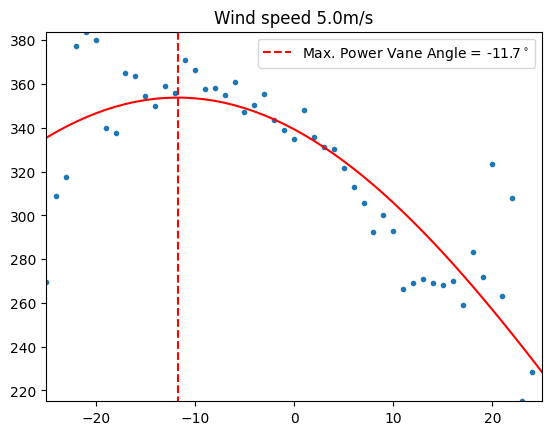

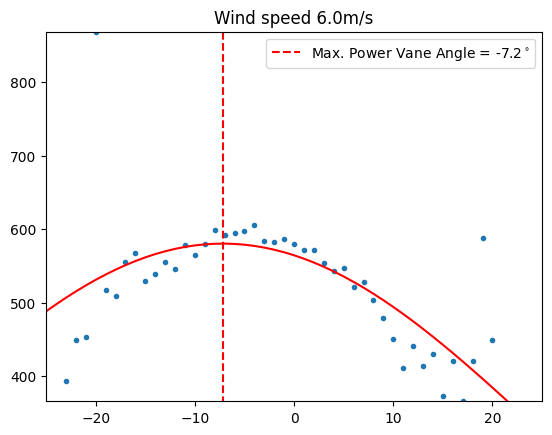

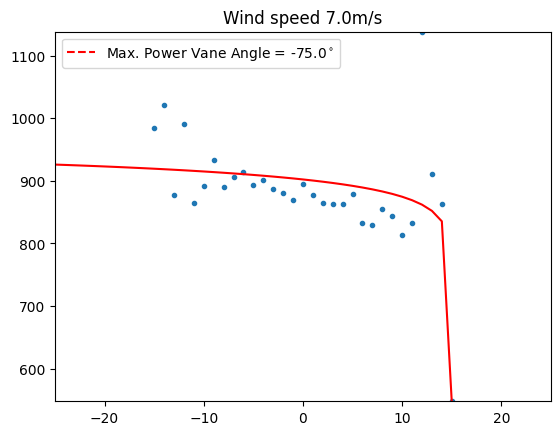

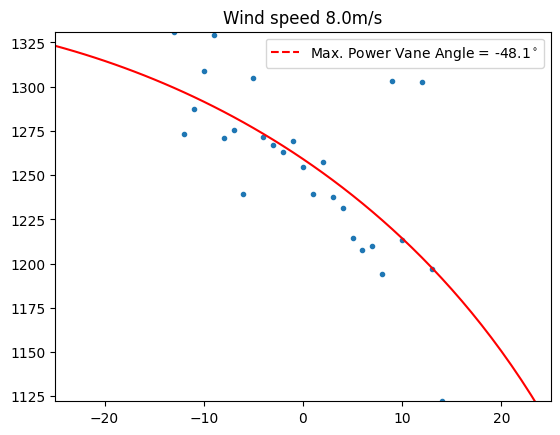

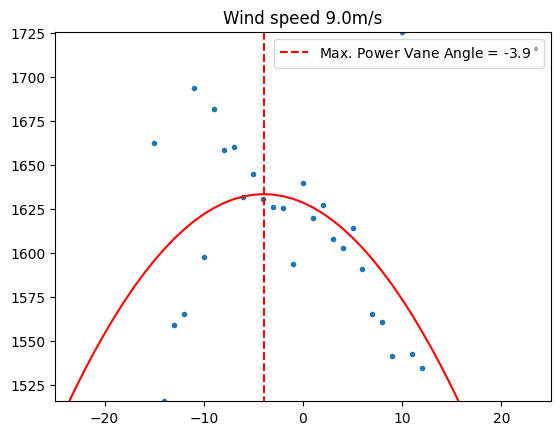

In [27]:
for ws_bin in set(kelmarsh_1_sye_data["ws_bin_left"]):
    kelmarsh_1_sye_ws_bin = kelmarsh_1_sye_data[kelmarsh_1_sye_data["ws_bin_left"]==ws_bin]
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.plot(kelmarsh_1_sye_ws_bin["yaw_bin_left"],kelmarsh_1_sye_ws_bin["Power (kW)"],marker=".",linestyle="")

    curve_fit_params = curve_fit(cos_curve, 
            kelmarsh_1_sye_ws_bin["yaw_bin_left"], 
            kelmarsh_1_sye_ws_bin["Power (kW)"], 
            [kelmarsh_1_sye_ws_bin["Power (kW)"].max(), 0.0, 2.0])[0]

    ax.plot(vane_bins,cos_curve(vane_bins,*curve_fit_params),c="red")
    
    ax.plot(
        2*[curve_fit_params[1]],
        [
                kelmarsh_1_sye_ws_bin["Power (kW)"].max(),
                kelmarsh_1_sye_ws_bin["Power (kW)"].min(),
        ],
        color="red",
        linestyle="--",
        label=rf"Max. Power Vane Angle = {round(curve_fit_params[1],1)}$^\circ$",  # noqa: W605
        )

    plt.title(f"Wind speed {ws_bin}m/s")
    
    ax.legend()
    ax.set_xlim([-25,25])
    ax.set_ylim([kelmarsh_1_sye_ws_bin["Power (kW)"].min(),kelmarsh_1_sye_ws_bin["Power (kW)"].max()])

    

## A slightly better static yaw misalignment analysis (?)

Use the average wind speed across the site excluding the target turbine

In [28]:
scada_filtered = scada[(scada["Blade angle (pitch position) A (°)"]<1.5) 
                            & (scada["Blade angle (pitch position) A (°)"]>-1.5)]

In [ ]:
kelmarsh_others = scada_filtered[scada_filtered["Turbine"]!=target_turbine]

In [30]:
site_wind_speed = kelmarsh_others.groupby("Timestamp")["Wind speed (m/s)"].mean()

In [31]:
kelmarsh_1_filtered["Site wind speed"] = site_wind_speed

C:\Users\Charlie\AppData\Local\Temp\ipykernel_14256\4254037099.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kelmarsh_1_filtered["Site wind speed"] = site_wind_speed


In [32]:
kelmarsh_1_filtered['site_ws_bin'] = pd.cut(kelmarsh_1_filtered['Site wind speed'], ws_bins)

C:\Users\Charlie\AppData\Local\Temp\ipykernel_14256\3762585294.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kelmarsh_1_filtered['site_ws_bin'] = pd.cut(kelmarsh_1_filtered['Site wind speed'], ws_bins)


In [33]:
kelmarsh_1_filtered

,Wind speed (m/s),Wind direction (°),Nacelle position (°),Power (kW),Blade angle (pitch position) A (°),Yaw error,ws_bin,yaw_bin,Site wind speed,site_ws_bin
Timestamp,,,,,,,,,,
2022-01-01 00:00:00,6.781222,185.795348,193.731354,630.889598,0.000000,7.936005,"(6.0, 7.0]","(7.0, 8.0]",6.280877,"(6.0, 7.0]"
2022-01-01 00:10:00,6.936052,189.458687,193.731354,809.339449,0.000000,4.272666,"(6.0, 7.0]","(4.0, 5.0]",6.562790,"(6.0, 7.0]"
2022-01-01 00:20:00,7.294642,188.648729,193.731354,893.607333,0.047000,5.082625,"(7.0, 8.0]","(5.0, 6.0]",6.451552,"(6.0, 7.0]"
2022-01-01 00:30:00,8.080467,188.826550,193.731354,995.583734,0.006500,4.904804,"(8.0, 9.0]","(4.0, 5.0]",6.782239,"(6.0, 7.0]"
2022-01-01 00:40:00,7.021328,191.252213,193.731354,926.519441,0.006000,2.479140,"(7.0, 8.0]","(2.0, 3.0]",7.170489,"(7.0, 8.0]"
...,...,...,...,...,...,...,...,...,...,...
2022-12-31 22:40:00,8.943925,222.929987,227.755859,1437.142835,0.259474,4.825872,"(8.0, 9.0]","(4.0, 5.0]",8.602252,"(8.0, 9.0]"
2022-12-31 22:50:00,8.366701,216.027913,220.507626,1108.914258,0.000000,4.479713,"(8.0, 9.0]","(4.0, 5.0]",7.648544,"(7.0, 8.0]"
2022-12-31 23:00:00,9.200417,212.180970,215.682648,1434.521783,0.469000,3.501678,"(9.0, 10.0]","(3.0, 4.0]",8.019866,"(8.0, 9.0]"


In [34]:
kelmarsh_1_sye_v2 = kelmarsh_1_filtered.groupby(by=["site_ws_bin","yaw_bin"])["Power (kW)"].median()#/kelmarsh_1_filtered.groupby(by=["site_ws_bin"])["Power (kW)"].median()
kelmarsh_1_sye_v2 = kelmarsh_1_sye_v2.reset_index()

C:\Users\Charlie\AppData\Local\Temp\ipykernel_14256\1133384382.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  kelmarsh_1_sye_v2 = kelmarsh_1_filtered.groupby(by=["site_ws_bin","yaw_bin"])["Power (kW)"].median()#/kelmarsh_1_filtered.groupby(by=["site_ws_bin"])["Power (kW)"].median()


In [35]:
kelmarsh_1_sye_v2["ws_bin_left"] = pd.IntervalIndex(kelmarsh_1_sye_v2['site_ws_bin']).left
kelmarsh_1_sye_v2["yaw_bin_left"] = pd.IntervalIndex(kelmarsh_1_sye_v2['yaw_bin']).left

kelmarsh_1_sye_v2 = kelmarsh_1_sye_v2.dropna()

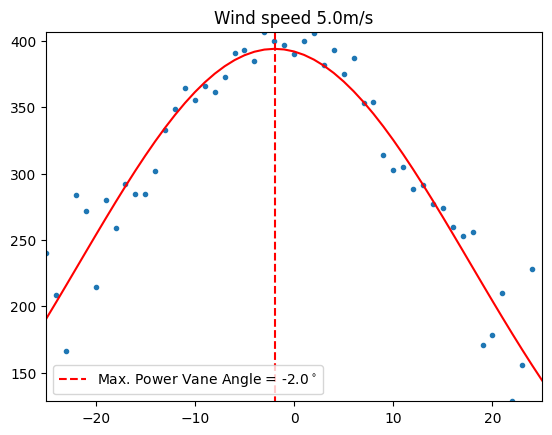

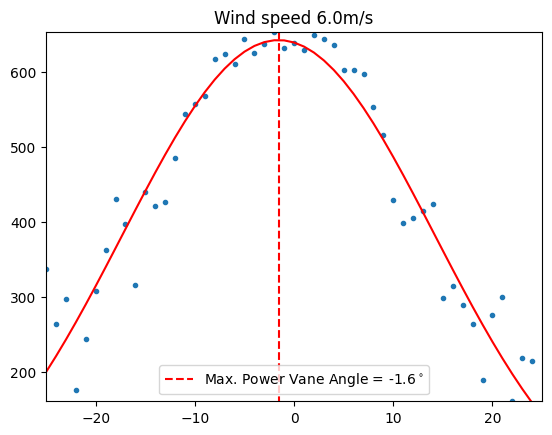

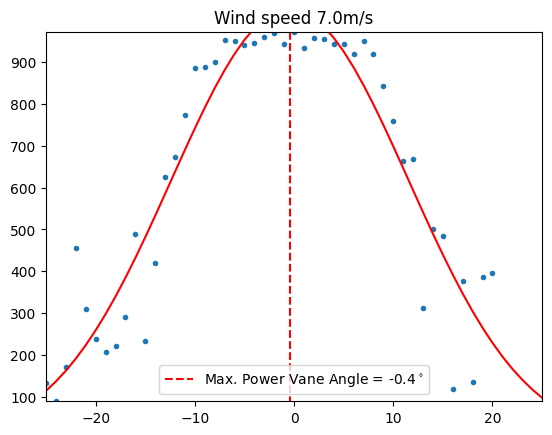

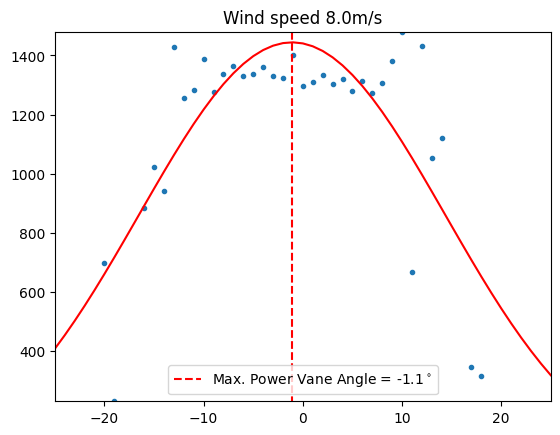

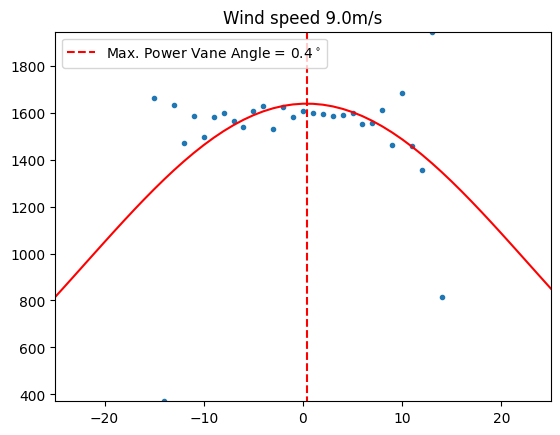

In [36]:
for ws_bin in set(kelmarsh_1_sye_v2["ws_bin_left"]):
    kelmarsh_1_sye_ws_bin = kelmarsh_1_sye_v2[kelmarsh_1_sye_v2["ws_bin_left"]==ws_bin]
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.plot(kelmarsh_1_sye_ws_bin["yaw_bin_left"],kelmarsh_1_sye_ws_bin["Power (kW)"],marker=".",linestyle="")

    curve_fit_params = curve_fit(cos_curve, 
            kelmarsh_1_sye_ws_bin["yaw_bin_left"], 
            kelmarsh_1_sye_ws_bin["Power (kW)"], 
            [kelmarsh_1_sye_ws_bin["Power (kW)"].max(), 0.0, 2.0])[0]

    ax.plot(vane_bins,cos_curve(vane_bins,*curve_fit_params),c="red")
    
    ax.plot(
        2*[curve_fit_params[1]],
        [
                kelmarsh_1_sye_ws_bin["Power (kW)"].max(),
                kelmarsh_1_sye_ws_bin["Power (kW)"].min(),
        ],
        color="red",
        linestyle="--",
        label=rf"Max. Power Vane Angle = {round(curve_fit_params[1],1)}$^\circ$",  # noqa: W605
        )

    plt.title(f"Wind speed {ws_bin}m/s")
    
    ax.legend()
    ax.set_xlim([-25,25])
    ax.set_ylim([kelmarsh_1_sye_ws_bin["Power (kW)"].min(),kelmarsh_1_sye_ws_bin["Power (kW)"].max()])

    

# Better wind speed predictions for turbines

In [ ]:
target_turbine = target_turbine

In [38]:
scada_clean = scada[(scada["Turbine"]!=target_turbine) | ((scada["Turbine"]==target_turbine) & (scada["Blade angle (pitch position) A (°)"]<1.5) 
                            & (scada["Blade angle (pitch position) A (°)"]>-1.5))]


In [39]:
scada_clean = scada_clean.pivot(columns='Turbine').dropna().stack("Turbine").reset_index().set_index("Timestamp")

C:\Users\Charlie\AppData\Local\Temp\ipykernel_14256\4243526468.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  scada_clean = scada_clean.pivot(columns='Turbine').dropna().stack("Turbine").reset_index().set_index("Timestamp")


In [40]:
scada_clean

,Turbine,Wind speed (m/s),Wind direction (°),Nacelle position (°),Power (kW),Blade angle (pitch position) A (°),Yaw error
Timestamp,,,,,,,
2022-01-01 00:00:00,Kelmarsh_1,6.781222,185.795348,193.731354,630.889598,0.0000,7.936005
2022-01-01 00:00:00,Kelmarsh_2,6.649725,185.131387,193.410889,630.786577,0.0000,8.279502
2022-01-01 00:00:00,Kelmarsh_3,6.526749,191.038261,191.092590,593.362961,0.0000,0.054329
2022-01-01 00:00:00,Kelmarsh_4,6.736784,185.012514,191.375766,613.850131,0.0000,6.363253
2022-01-01 00:00:00,Kelmarsh_5,5.357348,179.017514,194.111094,306.639859,0.0000,15.093580
...,...,...,...,...,...,...,...
2022-12-31 23:20:00,Kelmarsh_2,9.295921,205.655455,213.166046,1642.098862,0.4495,7.510591
2022-12-31 23:20:00,Kelmarsh_3,7.491813,209.175400,213.043030,948.692542,0.0090,3.867630
2022-12-31 23:20:00,Kelmarsh_4,8.558841,204.447160,209.195862,1366.492517,0.4270,4.748701


In [41]:
scada_target = scada_clean[scada_clean["Turbine"]==target_turbine]

In [42]:
scada_others = scada_clean[scada_clean["Turbine"]!=target_turbine]

In [43]:
X = scada_others.pivot(columns='Turbine')
y = scada_target["Wind speed (m/s)"]

In [44]:
X.columns = [re.sub(r'[^a-zA-Z_0-9]','', '_'.join(map(str, col)).strip()) for col in X.columns]

In [45]:
X["target_feature"] = y

In [46]:
X

,Windspeedms_Kelmarsh_2,Windspeedms_Kelmarsh_3,Windspeedms_Kelmarsh_4,Windspeedms_Kelmarsh_5,Windspeedms_Kelmarsh_6,Winddirection_Kelmarsh_2,Winddirection_Kelmarsh_3,Winddirection_Kelmarsh_4,Winddirection_Kelmarsh_5,Winddirection_Kelmarsh_6,...,BladeanglepitchpositionA_Kelmarsh_3,BladeanglepitchpositionA_Kelmarsh_4,BladeanglepitchpositionA_Kelmarsh_5,BladeanglepitchpositionA_Kelmarsh_6,Yawerror_Kelmarsh_2,Yawerror_Kelmarsh_3,Yawerror_Kelmarsh_4,Yawerror_Kelmarsh_5,Yawerror_Kelmarsh_6,target_feature
Timestamp,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,6.649725,6.526749,6.736784,5.357348,6.133781,185.131387,191.038261,185.012514,179.017514,186.667529,...,0.0000,0.0000,0.000000,0.000,8.279502,0.054329,6.363253,15.093580,7.437901,6.781222
2022-01-01 00:10:00,7.172483,7.795904,6.162219,5.835054,5.848290,192.504344,191.514534,189.411207,181.017440,188.705565,...,0.1960,0.0000,0.000000,0.000,0.906545,-0.421944,-5.459333,13.313166,-6.295805,6.936052
2022-01-01 00:20:00,7.092553,7.577127,6.058528,5.845765,5.683789,194.524668,190.998761,191.300487,189.980120,190.236214,...,0.0000,0.0000,0.000000,0.000,-1.113780,0.093829,2.522211,4.286828,-7.826455,7.294642
2022-01-01 00:30:00,7.185699,7.774836,6.851648,6.018545,6.080469,193.599714,192.917400,195.926536,187.555708,194.271845,...,0.0180,0.0000,0.000000,0.000,-0.188826,-1.824809,-0.999015,6.997161,-11.862085,8.080467
2022-01-01 00:40:00,7.110317,7.358590,7.567326,7.133427,6.682785,196.950363,198.363411,197.504063,190.580199,197.900696,...,0.0000,0.0155,0.020000,0.000,-3.539474,-7.270820,-2.576542,-2.241580,-10.367238,7.021328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 22:40:00,8.998160,9.182801,8.787624,8.725830,7.316843,224.108538,227.294982,216.131241,217.985737,226.645701,...,0.2095,0.1245,0.533684,0.000,-0.522117,1.113954,7.332962,6.601432,-2.474310,8.943925
2022-12-31 22:50:00,8.588931,6.869543,7.945592,7.327238,7.511415,212.376561,222.112342,211.614355,217.158936,217.959984,...,0.0000,0.0000,0.000000,0.000,9.570002,6.296594,9.010378,-8.622895,6.156532,8.366701
2022-12-31 23:00:00,9.562916,6.708959,7.662811,8.838151,7.326496,207.312726,218.213063,206.663325,207.354326,211.801265,...,0.0000,0.0000,0.057000,0.000,5.451175,7.907457,2.532536,1.181715,1.370319,9.200417


In [47]:
# Training with AutoGluon
predictor = TabularPredictor(
    label="target_feature", 
    eval_metric='mae'
)
predictor.fit(
    train_data=X, 
    time_limit=60, 
    presets='best_quality', 
    num_gpus='auto', 
    num_cpus='auto'
)

No path specified. Models will be saved in: "AutogluonModels\ag-20250208_224351"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.2
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       6.08 GB / 15.94 GB (38.2%)
Disk Space Avail:   182.21 GB / 931.51 GB (19.6%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout 

In [48]:
target_prediction = predictor.predict(X)

In [49]:
target_prediction

Timestamp
2022-01-01 00:00:00    6.339536
2022-01-01 00:10:00    6.999846
2022-01-01 00:20:00    7.057889
2022-01-01 00:30:00    7.232408
2022-01-01 00:40:00    7.353151
                         ...   
2022-12-31 22:40:00    8.841059
2022-12-31 22:50:00    7.853122
2022-12-31 23:00:00    8.774181
2022-12-31 23:10:00    9.188684
2022-12-31 23:20:00    9.079039
Name: target_feature, Length: 39922, dtype: float32

In [50]:
target_result = pd.concat([scada_target,target_prediction],axis=1)

In [51]:
target_result

,Turbine,Wind speed (m/s),Wind direction (°),Nacelle position (°),Power (kW),Blade angle (pitch position) A (°),Yaw error,target_feature
Timestamp,,,,,,,,
2022-01-01 00:00:00,Kelmarsh_1,6.781222,185.795348,193.731354,630.889598,0.000000,7.936005,6.339536
2022-01-01 00:10:00,Kelmarsh_1,6.936052,189.458687,193.731354,809.339449,0.000000,4.272666,6.999846
2022-01-01 00:20:00,Kelmarsh_1,7.294642,188.648729,193.731354,893.607333,0.047000,5.082625,7.057889
2022-01-01 00:30:00,Kelmarsh_1,8.080467,188.826550,193.731354,995.583734,0.006500,4.904804,7.232408
2022-01-01 00:40:00,Kelmarsh_1,7.021328,191.252213,193.731354,926.519441,0.006000,2.479140,7.353151
...,...,...,...,...,...,...,...,...
2022-12-31 22:40:00,Kelmarsh_1,8.943925,222.929987,227.755859,1437.142835,0.259474,4.825872,8.841059
2022-12-31 22:50:00,Kelmarsh_1,8.366701,216.027913,220.507626,1108.914258,0.000000,4.479713,7.853122
2022-12-31 23:00:00,Kelmarsh_1,9.200417,212.180970,215.682648,1434.521783,0.469000,3.501678,8.774181


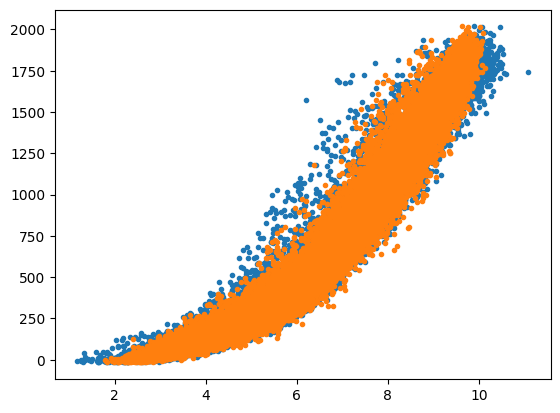

In [52]:
plt.figure()
plt.plot(target_result["Wind speed (m/s)"],target_result["Power (kW)"],marker='.',linestyle='')
plt.plot(target_result["target_feature"],target_result["Power (kW)"],marker='.',linestyle='')
plt.show()

In [53]:
np.mean(abs(target_result["target_feature"]-target_result["Wind speed (m/s)"]))

0.22612186344043878

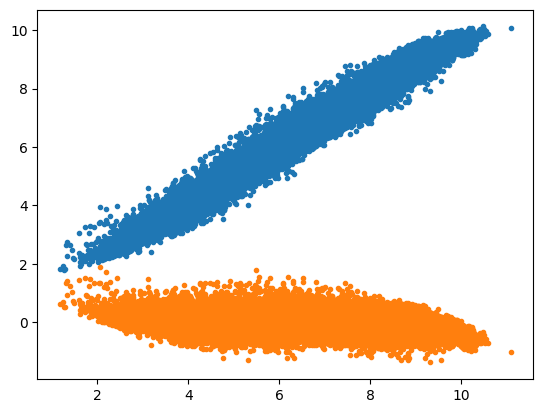

In [54]:
plt.figure()
plt.plot(target_result["Wind speed (m/s)"],target_result["target_feature"],marker='.',linestyle='')
plt.plot(target_result["Wind speed (m/s)"],target_result["target_feature"]-target_result["Wind speed (m/s)"],marker='.',linestyle='')
plt.show()

In [55]:
target_result_filtered = target_result[(target_result["Blade angle (pitch position) A (°)"]<1.5) 
                            & (target_result["Blade angle (pitch position) A (°)"]>-1.5)]

In [56]:
ws_bins=[5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
vane_bins=np.linspace(-25,25,51)

target_result_filtered['yaw_bin'] = pd.cut(target_result_filtered['Yaw error'], vane_bins)

# target_result_filtered['ws_bin'] = pd.cut(target_result_filtered['Wind speed (m/s)'], ws_bins)
target_result_filtered['ws_bin'] = pd.cut(target_result_filtered['target_feature'], ws_bins)

In [57]:
target_result_filtered_sye = target_result_filtered.groupby(by=["ws_bin","yaw_bin"]).agg(
    Median=("Power (kW)", 'median'),
    Count=("Power (kW)", 'count'),
    Mean=("Power (kW)", 'mean'))

target_result_filtered_sye = target_result_filtered_sye.reset_index()


C:\Users\Charlie\AppData\Local\Temp\ipykernel_14256\2937036510.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  target_result_filtered_sye = target_result_filtered.groupby(by=["ws_bin","yaw_bin"]).agg(


In [58]:
target_result_filtered_sye

,ws_bin,yaw_bin,Median,Count,Mean
0,"(5.0, 6.0]","(-25.0, -24.0]",270.239036,7,332.344560
1,"(5.0, 6.0]","(-24.0, -23.0]",293.510719,8,292.230693
2,"(5.0, 6.0]","(-23.0, -22.0]",314.383591,9,337.658293
3,"(5.0, 6.0]","(-22.0, -21.0]",315.579806,15,338.412065
4,"(5.0, 6.0]","(-21.0, -20.0]",342.746259,28,354.554229
...,...,...,...,...,...
245,"(9.0, 10.0]","(20.0, 21.0]",NaN,0,NaN
246,"(9.0, 10.0]","(21.0, 22.0]",NaN,0,NaN
247,"(9.0, 10.0]","(22.0, 23.0]",NaN,0,NaN
248,"(9.0, 10.0]","(23.0, 24.0]",NaN,0,NaN


In [59]:
target_result_filtered_sye["ws_bin_left"] = pd.IntervalIndex(target_result_filtered_sye['ws_bin']).left
target_result_filtered_sye["yaw_bin_left"] = pd.IntervalIndex(target_result_filtered_sye['yaw_bin']).left

sye_data = target_result_filtered_sye.dropna()

In [60]:
sye_data

,ws_bin,yaw_bin,Median,Count,Mean,ws_bin_left,yaw_bin_left
0,"(5.0, 6.0]","(-25.0, -24.0]",270.239036,7,332.344560,5.0,-25.0
1,"(5.0, 6.0]","(-24.0, -23.0]",293.510719,8,292.230693,5.0,-24.0
2,"(5.0, 6.0]","(-23.0, -22.0]",314.383591,9,337.658293,5.0,-23.0
3,"(5.0, 6.0]","(-22.0, -21.0]",315.579806,15,338.412065,5.0,-22.0
4,"(5.0, 6.0]","(-21.0, -20.0]",342.746259,28,354.554229,5.0,-21.0
...,...,...,...,...,...,...,...
234,"(9.0, 10.0]","(9.0, 10.0]",1662.342973,24,1650.676925,9.0,9.0
235,"(9.0, 10.0]","(10.0, 11.0]",1712.843805,11,1721.353713,9.0,10.0
236,"(9.0, 10.0]","(11.0, 12.0]",1661.294327,2,1661.294327,9.0,11.0
237,"(9.0, 10.0]","(12.0, 13.0]",1534.892221,1,1534.892221,9.0,12.0


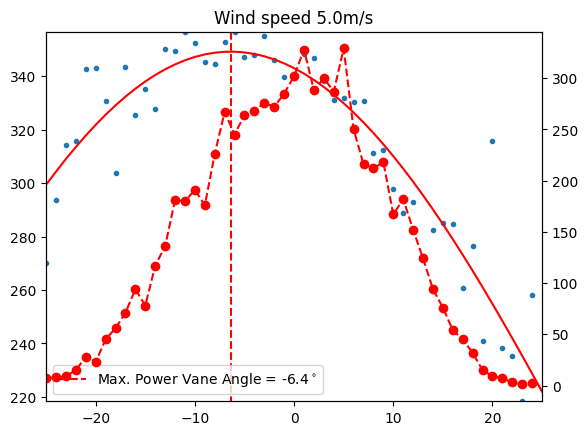

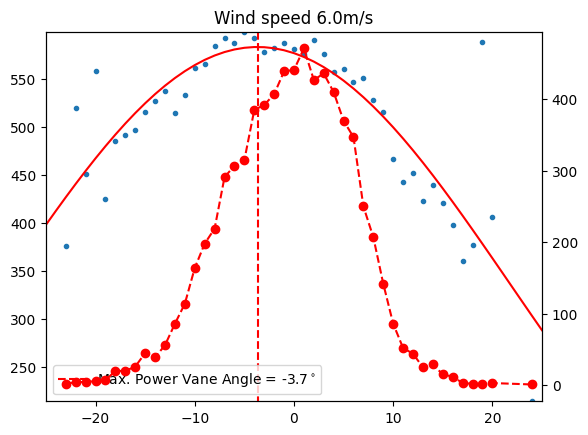

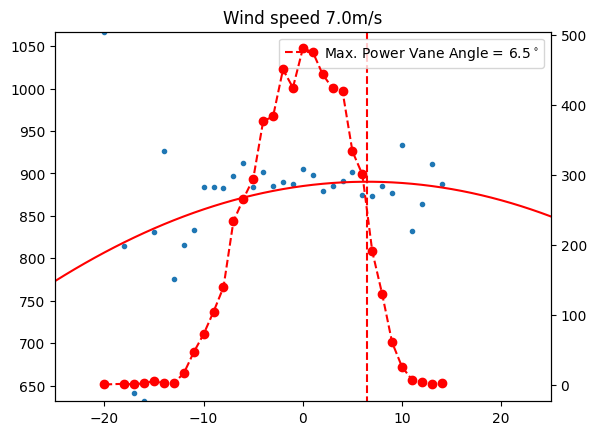

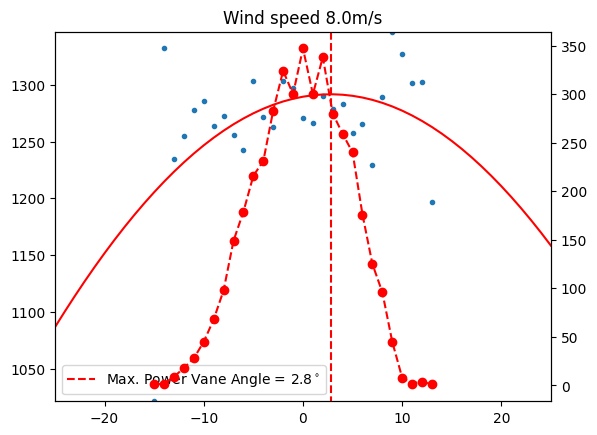

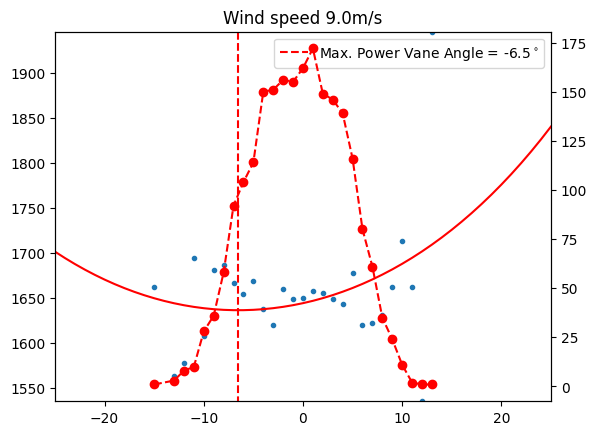

In [61]:
for ws_bin in set(sye_data["ws_bin_left"]):
    sye_ws_bin = sye_data[sye_data["ws_bin_left"]==ws_bin]
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.plot(sye_ws_bin["yaw_bin_left"],sye_ws_bin["Median"],marker=".",linestyle="")

    curve_fit_params = curve_fit(cos_curve, 
            sye_ws_bin["yaw_bin_left"], 
            sye_ws_bin["Median"], 
            [sye_ws_bin["Median"].max(), 0.0, 2.0])[0]

    ax.plot(vane_bins,cos_curve(vane_bins,*curve_fit_params),c="red")
    
    ax.plot(
        2*[curve_fit_params[1]],
        [
                sye_ws_bin["Median"].max(),
                sye_ws_bin["Median"].min(),
        ],
        color="red",
        linestyle="--",
        label=rf"Max. Power Vane Angle = {round(curve_fit_params[1],1)}$^\circ$",  # noqa: W605
        )
    
    ax2 = ax.twinx()
    ax2.plot(sye_ws_bin["yaw_bin_left"], sye_ws_bin["Count"], marker="o", linestyle="--", color="red", label="Count")

    plt.title(f"Wind speed {ws_bin}m/s")
    
    ax.legend()
    ax.set_xlim([-25,25])
    ax.set_ylim([sye_ws_bin["Median"].min(),sye_ws_bin["Median"].max()])

# Yaw error predictions

Can I predict yaw error from the other turbine data? If so this could impact the result.

Oh shit! I can!! And pretty well.

In [62]:
X = scada_others.pivot(columns='Turbine')
y = scada_target["Yaw error"]

In [63]:
X.columns = [re.sub(r'[^a-zA-Z_0-9]','', '_'.join(map(str, col)).strip()) for col in X.columns]

In [64]:
X["target_feature"] = y

In [ ]:
# Training with AutoGluon
predictor = TabularPredictor(
    label="target_feature", 
    eval_metric='mae'
)
predictor.fit(
    train_data=X, 
    time_limit=60*autoML_duration_mins, 
    presets='best_quality', 
    num_gpus='auto', 
    num_cpus='auto'
)

No path specified. Models will be saved in: "AutogluonModels\ag-20250208_224507"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.2
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       5.49 GB / 15.94 GB (34.5%)
Disk Space Avail:   182.11 GB / 931.51 GB (19.5%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout 

KeyboardInterrupt: 

In [ ]:
target_prediction = predictor.predict(X)

In [ ]:
predictor.feature_importance(X)

Computing feature importance via permutation shuffling for 30 features using 5000 rows with 5 shuffle sets...
	2048.09s	= Expected runtime (409.62s per shuffle set)
	1613.05s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
Yawerror_Kelmarsh_2,1.083692,0.023097,2.474739e-08,5,1.131250,1.036135
Yawerror_Kelmarsh_3,0.927987,0.032029,1.700225e-07,5,0.993935,0.862038
Yawerror_Kelmarsh_4,0.893728,0.019801,2.889586e-08,5,0.934499,0.852957
Yawerror_Kelmarsh_5,0.772865,0.010643,4.313551e-09,5,0.794778,0.750952
Yawerror_Kelmarsh_6,0.751086,0.032845,4.376974e-07,5,0.818713,0.683458
Nacelleposition_Kelmarsh_3,0.646402,0.012771,1.827259e-08,5,0.672697,0.620107
Nacelleposition_Kelmarsh_6,0.628242,0.012966,2.175683e-08,5,0.654939,0.601546
PowerkW_Kelmarsh_4,0.625349,0.013515,2.616577e-08,5,0.653178,0.597521
PowerkW_Kelmarsh_2,0.622948,0.014051,3.103805e-08,5,0.651879,0.594017
Nacelleposition_Kelmarsh_2,0.621893,0.015161,4.234855e-08,5,0.653109,0.590677


In [ ]:
target_result = pd.concat([scada_target,target_prediction],axis=1)

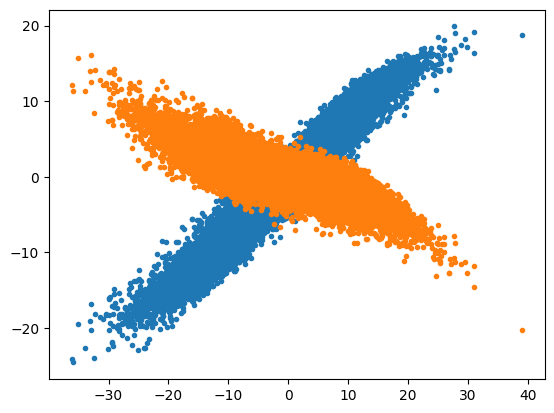

In [ ]:
plt.figure()
plt.plot(target_result["Yaw error"],target_result["target_feature"],marker='.',linestyle='')
plt.plot(target_result["Yaw error"],target_result["target_feature"]-target_result["Yaw error"],marker='.',linestyle='')
plt.show()

# Power predictions

Can these be used instead? 

But then it will also account for the yaw error, such that if there is one, it will also predict (lower) power outputs to get a better MAE :/

Perhaps though I could use that with some synthetic data, i.e. keep all variables the same, but just change the yaw error at the target turbine, to see what that results in.

In [ ]:
target_feature = "Power (kW)"

In [ ]:
X = scada_others.pivot(columns='Turbine')
y = scada_target[target_feature]

In [ ]:
X.columns = [re.sub(r'[^a-zA-Z_0-9]','', '_'.join(map(str, col)).strip()) for col in X.columns]

In [ ]:
X["target_feature"] = y

In [ ]:
X

,Windspeedms_Kelmarsh_2,Windspeedms_Kelmarsh_3,Windspeedms_Kelmarsh_4,Windspeedms_Kelmarsh_5,Windspeedms_Kelmarsh_6,Winddirection_Kelmarsh_2,Winddirection_Kelmarsh_3,Winddirection_Kelmarsh_4,Winddirection_Kelmarsh_5,Winddirection_Kelmarsh_6,...,BladeanglepitchpositionA_Kelmarsh_3,BladeanglepitchpositionA_Kelmarsh_4,BladeanglepitchpositionA_Kelmarsh_5,BladeanglepitchpositionA_Kelmarsh_6,Yawerror_Kelmarsh_2,Yawerror_Kelmarsh_3,Yawerror_Kelmarsh_4,Yawerror_Kelmarsh_5,Yawerror_Kelmarsh_6,target_feature
Timestamp,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,6.649725,6.526749,6.736784,5.357348,6.133781,185.131387,191.038261,185.012514,179.017514,186.667529,...,0.0000,0.0000,0.000000,0.000,8.279502,0.054329,6.363253,15.093580,7.437901,630.889598
2022-01-01 00:10:00,7.172483,7.795904,6.162219,5.835054,5.848290,192.504344,191.514534,189.411207,181.017440,188.705565,...,0.1960,0.0000,0.000000,0.000,0.906545,-0.421944,-5.459333,13.313166,-6.295805,809.339449
2022-01-01 00:20:00,7.092553,7.577127,6.058528,5.845765,5.683789,194.524668,190.998761,191.300487,189.980120,190.236214,...,0.0000,0.0000,0.000000,0.000,-1.113780,0.093829,2.522211,4.286828,-7.826455,893.607333
2022-01-01 00:30:00,7.185699,7.774836,6.851648,6.018545,6.080469,193.599714,192.917400,195.926536,187.555708,194.271845,...,0.0180,0.0000,0.000000,0.000,-0.188826,-1.824809,-0.999015,6.997161,-11.862085,995.583734
2022-01-01 00:40:00,7.110317,7.358590,7.567326,7.133427,6.682785,196.950363,198.363411,197.504063,190.580199,197.900696,...,0.0000,0.0155,0.020000,0.000,-3.539474,-7.270820,-2.576542,-2.241580,-10.367238,926.519441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 22:40:00,8.998160,9.182801,8.787624,8.725830,7.316843,224.108538,227.294982,216.131241,217.985737,226.645701,...,0.2095,0.1245,0.533684,0.000,-0.522117,1.113954,7.332962,6.601432,-2.474310,1437.142835
2022-12-31 22:50:00,8.588931,6.869543,7.945592,7.327238,7.511415,212.376561,222.112342,211.614355,217.158936,217.959984,...,0.0000,0.0000,0.000000,0.000,9.570002,6.296594,9.010378,-8.622895,6.156532,1108.914258
2022-12-31 23:00:00,9.562916,6.708959,7.662811,8.838151,7.326496,207.312726,218.213063,206.663325,207.354326,211.801265,...,0.0000,0.0000,0.057000,0.000,5.451175,7.907457,2.532536,1.181715,1.370319,1434.521783


In [ ]:
# Training with AutoGluon
predictor = TabularPredictor(
    label="target_feature", 
    eval_metric='mae'
)
predictor.fit(
    train_data=X, 
    time_limit=60*autoML_duration_mins, 
    presets='best_quality', 
    num_gpus='auto', 
    num_cpus='auto'
)

No path specified. Models will be saved in: "AutogluonModels\ag-20250128_225051"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.2
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       6.30 GB / 15.94 GB (39.5%)
Disk Space Avail:   200.21 GB / 931.51 GB (21.5%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout 

In [ ]:
target_prediction = predictor.predict(X)

In [ ]:
target_result = pd.concat([scada_target,target_prediction],axis=1)

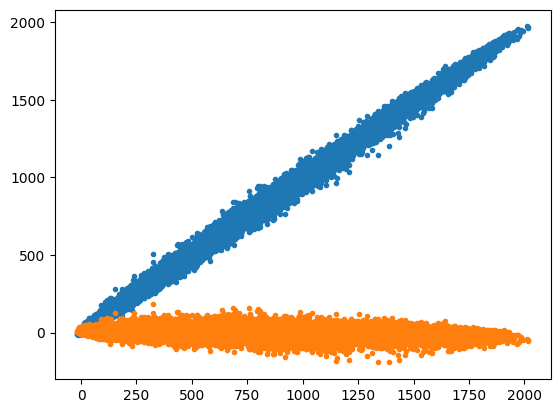

In [ ]:
plt.figure()
plt.plot(target_result[target_feature],target_result["target_feature"],marker='.',linestyle='')
plt.plot(target_result[target_feature],target_result["target_feature"]-target_result[target_feature],marker='.',linestyle='')
plt.show()

In [ ]:
X["Yawerror_Kelmarsh_1"] = scada_target["Yaw error"] # include yaw error to use as a variable to change and find the power output predicted

In [ ]:
# Training with AutoGluon
predictor = TabularPredictor(
    label="target_feature", 
    eval_metric='mae'
)
predictor.fit(
    train_data=X, 
    time_limit=60*autoML_duration_mins, 
    presets='best_quality', 
    num_gpus='auto', 
    num_cpus='auto'
)

No path specified. Models will be saved in: "AutogluonModels\ag-20250128_231101"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.2
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       6.49 GB / 15.94 GB (40.7%)
Disk Space Avail:   199.22 GB / 931.51 GB (21.4%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout 

In [ ]:
target_prediction = predictor.predict(X)

In [ ]:
target_result = pd.concat([scada_target,target_prediction],axis=1)

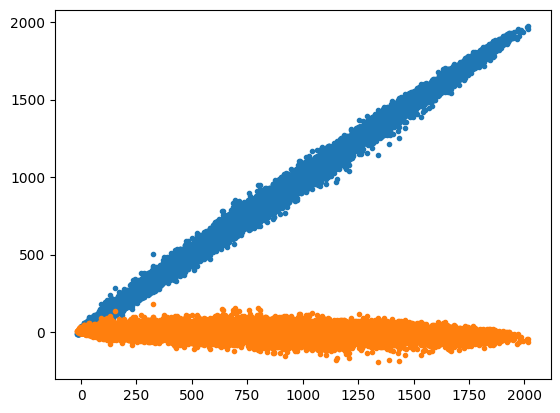

In [ ]:
plt.figure()
plt.plot(target_result[target_feature],target_result["target_feature"],marker='.',linestyle='')
plt.plot(target_result[target_feature],target_result["target_feature"]-target_result[target_feature],marker='.',linestyle='')
plt.show()